In [80]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

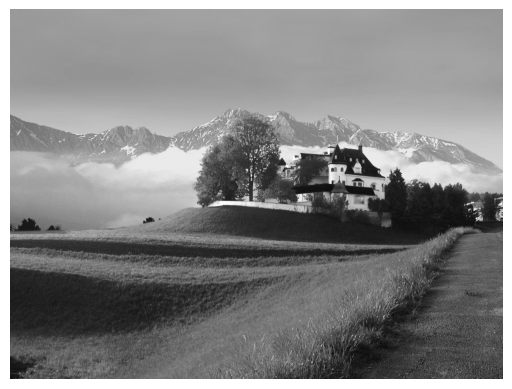

Image shape: (768, 1024)


In [82]:
I = cv2.imread("sample4.jpg", 1)
I = cv2.cvtColor(I, cv2.COLOR_RGB2GRAY)
plt.imshow(I, cmap="gray")
plt.axis("off")
plt.show()
print("Image shape:", I.shape)

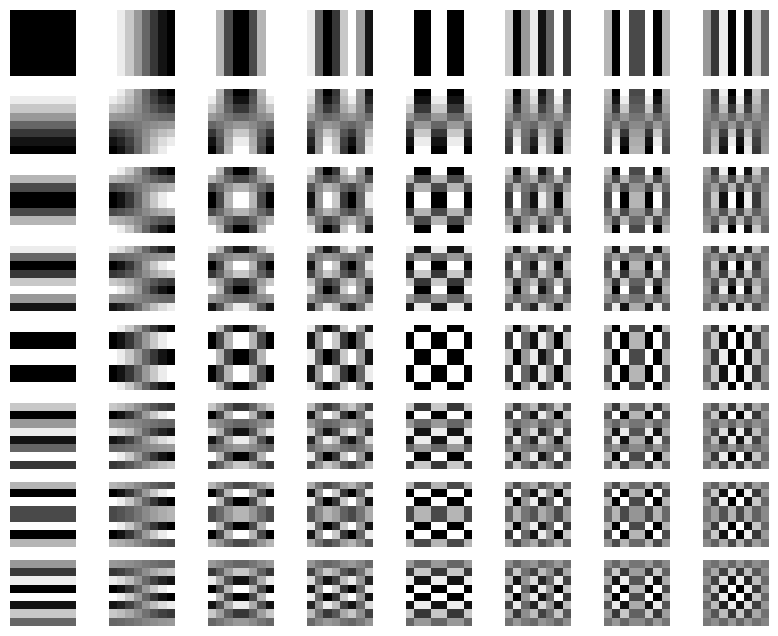

In [3]:
coef_base = np.zeros((8, 8, 8, 8))
for u in range(8):
    for v in range(8):
        for x in range(8):
            for y in range(8):
                coef_base[u, v, x, y] = np.cos(((2 * x + 1) * u * np.pi) / 16) * np.cos(((2 * y + 1) * v * np.pi) / 16)
fig, axes = plt.subplots(8, 8, figsize=(10, 8))
for u in range(8):
    for v in range(8):
        axes[u, v].imshow(coef_base[u, v], cmap="gray")
        axes[u, v].axis("off")
plt.show()

In [4]:
I[...]

array([[121, 121, 121, ..., 116, 116, 116],
       [121, 121, 121, ..., 117, 117, 117],
       [121, 121, 121, ..., 117, 117, 117],
       ...,
       [ 22,  26,  25, ...,  63,  67,  41],
       [ 16,  19,  19, ...,  56,  72,  60],
       [ 22,  21,  18, ...,  59,  34,  79]], dtype=uint8)

In [5]:
def QQC(degree):
    newQ = np.zeros((8, 8), dtype=np.uint8)
    if 1 < degree < 50:
        for i in range(8):
            for j in range(8):
                newQ[i, j] = np.clip((50 / degree) * Q[i, j], 0, 255)
        return newQ
    elif 50 < degree < 100:
        for i in range(8):
            for j in range(8):
                newQ[i, j] = np.clip(((100 - degree) / 50) * Q[i, j], 0, 255)
        return newQ
    elif degree == 50:
        return Q
    else:
        return "sorry but not possible"


Q = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
              [12, 12, 14, 19, 26, 58, 60, 55],
              [14, 13, 16, 24, 40, 57, 69, 56],
              [14, 17, 22, 29, 51, 87, 80, 62],
              [18, 22, 37, 56, 68, 109, 103, 77],
              [24, 35, 55, 64, 81, 104, 113, 92],
              [49, 64, 78, 87, 103, 121, 120, 101],
              [72, 92, 95, 98, 112, 100, 103, 99]])
QQC(90)
QQC(50)
QQC(10)

array([[ 80,  55,  50,  80, 120, 200, 255, 255],
       [ 60,  60,  70,  95, 130, 255, 255, 255],
       [ 70,  65,  80, 120, 200, 255, 255, 255],
       [ 70,  85, 110, 145, 255, 255, 255, 255],
       [ 90, 110, 185, 255, 255, 255, 255, 255],
       [120, 175, 255, 255, 255, 255, 255, 255],
       [245, 255, 255, 255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255]], dtype=uint8)

In [6]:
num_blocks = (I.shape[0] // 8, I.shape[1] // 8)
blocks = np.empty((num_blocks[0], num_blocks[1], 8, 8))
for i, k in zip(range(0, num_blocks[0]), range(0, I.shape[0], 8)):
    for j, l in zip(range(0, num_blocks[1]), range(0, I.shape[1], 8)):
        blocks[i, j] = I[k:k + 8, l:l + 8]
width, height, _, _ = blocks.shape

In [7]:
blocks[95, 127]

array([[ 71., 118.,  92.,  64.,  47.,  73.,  61.,  36.],
       [ 50., 185., 110.,  69.,  26.,  85.,  90.,  64.],
       [ 64., 113.,  87.,  43.,  61.,  77.,  93.,  72.],
       [ 80.,  88.,  68.,  62.,  67., 113.,  75.,  46.],
       [128.,  99.,  62.,  55.,  94.,  66.,  64.,  39.],
       [ 84.,  96.,  65.,  60.,  54.,  63.,  67.,  41.],
       [ 36.,  51., 120.,  61.,  76.,  56.,  72.,  60.],
       [ 66.,  65.,  93.,  54.,  72.,  59.,  34.,  79.]])

In [8]:
def DCT(arr):
    width, height, _, _ = arr.shape
    result = np.zeros_like(arr)
    g_x = arr - 128
    for row in range(width):
        for column in range(height):
            for u in range(8):
                au = 1
                if u == 0: au = (1 / np.sqrt(2))
                for v in range(8):
                    sumGx = 0
                    av = 1
                    if v == 0: av = (1 / np.sqrt(2))
                    for x in range(8):
                        for y in range(8):
                            sumGx = sumGx + g_x[row, column, x, y] * np.cos(((2 * x + 1) * u * np.pi) / 16) * np.cos(
                                ((2 * y + 1) * v * np.pi) / 16)
                    result[row, column, u, v] = (1 / 4) * au * av * sumGx
    return result

dct = DCT(blocks)

In [52]:
def quantizition(arr, Q):
    quant = QQC(Q)
    finalStep = np.zeros_like(arr)
    for i in range(width):
        for j in range(height):
            for x in range(8):
                for y in range(8):
                    finalStep[i, j, x, y] = round(arr[i, j, x, y] / quant[x, y])
    return finalStep

qun = quantizition(dct, 50)

In [42]:
qun[70, 30]

array([[-17.,  -3.,   2.,  -2.,   1.,   0.,   0.,   0.],
       [  3.,   3.,  -2.,   0.,   0.,   0.,   0.,   0.],
       [  4.,   0.,  -1.,   0.,   0.,   1.,   0.,   0.],
       [  5.,  -3.,  -1.,   0.,   0.,   0.,   0.,   0.],
       [  0.,  -1.,   0.,   0.,   0.,   0.,   0.,   0.],
       [ -1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]])

In [53]:
def energy_left(arr, energy):
    qunP = np.copy(arr)
    leftEnergy = round(8*energy/100)
    for i in range(width):
        for j in range(height):
            qunP[i, j, leftEnergy:] = 0
            qunP[i, j, :, leftEnergy:] = 0
    return qunP
newImg_70 = energy_left(qun, 70)
newImg_50 = energy_left(qun, 50)
newImg_30 = energy_left(qun, 30)

In [55]:
newImg_50[70, 30]

array([[-17.,  -3.,   2.,  -2.,   0.,   0.,   0.,   0.],
       [  3.,   3.,  -2.,   0.,   0.,   0.,   0.,   0.],
       [  4.,   0.,  -1.,   0.,   0.,   0.,   0.,   0.],
       [  5.,  -3.,  -1.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]])

In [118]:
def inv_DCT(arr):
    width, height, _, _ = arr.shape
    result = np.zeros_like(arr)
    g_x = np.copy(arr)
    for row in range(width):
        for column in range(height):
            for u in range(8):
                au = 1 / np.sqrt(8)
                if u == 0: au = (1 / 2)
                for v in range(8):
                    sumGx = 0
                    av = 1 / np.sqrt(8)
                    if v == 0: av = (1 / 2)
                    for x in range(8):
                        for y in range(8):
                            sumGx = sumGx + g_x[row, column, x, y] * np.cos(((2 * x + 1) * u * np.pi) / 16) * np.cos(
                                ((2 * y + 1) * v * np.pi) / 16)
                    result[row, column, u, v] = (1 / 4) * au * av * sumGx
    result += 128
    return result

In [131]:
inv_dct_30 = inv_DCT(np.array(newImg_30))
inv_dct_50 = inv_DCT(np.array(newImg_50))
inv_dct_70 = inv_DCT(np.array(newImg_70))

In [120]:
inv_dct_70[70, 30]

array([[127.25      , 127.49342111, 127.7451124 , 128.01770463,
        127.9375    , 127.88995827, 128.03792839, 128.06627738],
       [127.46343809, 127.62324976, 127.71605415, 127.81618229,
        127.76418349, 127.7620874 , 127.91423749, 128.01499152],
       [127.24114062, 127.46209572, 127.44064078, 127.42241667,
        127.44033756, 127.52849716, 127.76608496, 127.99707919],
       [127.00150553, 127.32637819, 127.32249278, 127.33315028,
        127.47246183, 127.63445002, 127.87419099, 128.09280483],
       [127.1875    , 127.47461412, 127.54301375, 127.64086123,
        127.8125    , 127.96218374, 128.12164039, 128.20205091],
       [127.47671514, 127.63666847, 127.70479213, 127.82195002,
        127.91649387, 128.0342672 , 128.16567941, 128.16384662],
       [127.63783472, 127.69281998, 127.70358496, 127.7805538 ,
        127.79209794, 127.9042216 , 128.05935922, 128.05516624],
       [127.83501345, 127.82749152, 127.80704925, 127.83794417,
        127.82064656, 127.8992089

In [121]:
inv_dct_50[70, 30]

array([[127.25      , 127.60668704, 127.86059734, 127.97793093,
        127.9375    , 127.91653421, 127.99009296, 128.04374739],
       [127.3623653 , 127.61677768, 127.73264156, 127.76888011,
        127.74682192, 127.78729249, 127.90891508, 127.99936652],
       [127.15948043, 127.4253496 , 127.44064078, 127.41379481,
        127.42342518, 127.57184215, 127.81027913, 127.97252622],
       [127.07600237, 127.35891556, 127.36972974, 127.37087237,
        127.44181229, 127.65007502, 127.90813997, 128.03817037],
       [127.1875    , 127.46334912, 127.54301375, 127.62757326,
        127.75      , 127.94229689, 128.12164039, 128.14541795],
       [127.39817235, 127.61585877, 127.70758926, 127.80632502,
        127.92259044, 128.07198928, 128.18836339, 128.165134  ],
       [127.60400997, 127.72956609, 127.74777913, 127.77193194,
        127.83292803, 127.94756659, 128.05935922, 128.07971921],
       [127.79624436, 127.84311652, 127.81034869, 127.78148908,
        127.79466314, 127.8648509

In [122]:
inv_dct_30[70, 30]

array([[127.125     , 127.39317007, 127.4283787 , 127.48555442,
        127.5625    , 127.65625846, 127.76322671, 127.87929402],
       [127.35357677, 127.55378279, 127.58527952, 127.63431349,
        127.69658503, 127.7675607 , 127.84336885, 127.92133412],
       [127.28487242, 127.51162062, 127.56027913, 127.63163417,
        127.71418935, 127.79701421, 127.87277913, 127.93943474],
       [127.21334661, 127.46881034, 127.53817862, 127.63629286,
        127.74277721, 127.83882405, 127.91287674, 127.96372498],
       [127.1875    , 127.45631171, 127.54096194, 127.65840444,
        127.78125   , 127.88450531, 127.9533665 , 127.98744035],
       [127.24887068, 127.50058328, 127.5872514 , 127.70624152,
        127.82812923, 127.92620714, 127.98493448, 128.00450208],
       [127.41677188, 127.6138094 , 127.68527913, 127.78284175,
        127.88161335, 127.95906892, 128.00222087, 128.01149248],
       [127.68024508, 127.7887516 , 127.8291964 , 127.88424756,
        127.93964701, 127.9825052

In [132]:
def restord(img):
    cp = np.copy(img)
    new_Img = np.empty((I.shape[0], I.shape[1]), dtype = np.uint8)
    for i, k in zip(range(0, num_blocks[0]), range(0, I.shape[0], 8)):
        for j, l in zip(range(0, num_blocks[1]), range(0, I.shape[1], 8)):
            new_Img[k:k + 8, l:l + 8] = cp[i, j]
    return new_Img

In [133]:
new_Img_30 = restord(inv_dct_30)
new_Img_50 = restord(inv_dct_50)
new_Img_70 = restord(inv_dct_70)

In [126]:
I[600:, :100]

array([[37, 31, 29, ..., 34, 22, 35],
       [32, 36, 38, ..., 38, 25, 31],
       [28, 37, 41, ..., 40, 31, 32],
       ...,
       [22, 26, 25, ..., 91, 94, 89],
       [17, 20, 20, ..., 96, 94, 77],
       [23, 22, 19, ..., 88, 65, 59]], dtype=uint8)

In [134]:
new_Img_30[600:, :100]

array([[125, 125, 126, ..., 125, 126, 126],
       [125, 126, 126, ..., 126, 126, 126],
       [126, 126, 126, ..., 126, 126, 126],
       ...,
       [126, 127, 127, ..., 127, 127, 127],
       [127, 127, 127, ..., 127, 127, 127],
       [127, 127, 127, ..., 127, 127, 127]], dtype=uint8)

In [135]:
new_Img_50[600:, :100]

array([[125, 125, 126, ..., 125, 125, 126],
       [125, 126, 126, ..., 126, 126, 126],
       [126, 126, 126, ..., 126, 126, 126],
       ...,
       [126, 127, 127, ..., 127, 127, 127],
       [127, 127, 127, ..., 127, 127, 127],
       [127, 127, 127, ..., 127, 127, 127]], dtype=uint8)

In [136]:
new_Img_70[600:, :100]

array([[125, 125, 126, ..., 125, 125, 126],
       [125, 126, 126, ..., 126, 126, 126],
       [126, 126, 126, ..., 126, 126, 126],
       ...,
       [126, 127, 127, ..., 127, 127, 127],
       [127, 127, 127, ..., 127, 127, 127],
       [127, 127, 127, ..., 127, 127, 127]], dtype=uint8)

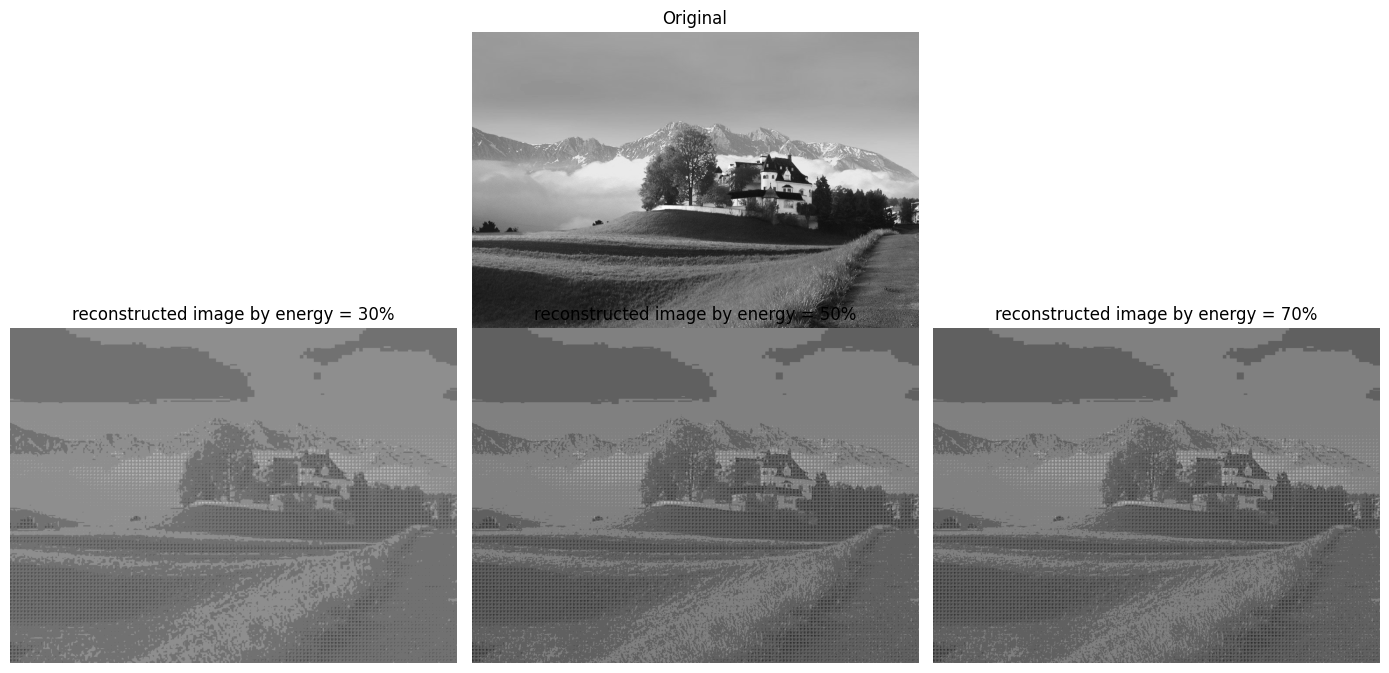

In [137]:
fig = plt.figure(figsize=(14, 12))
# fig , axe = plt.subplots(nrows=2, ncols=3, figsize=(12, 10))
plt.subplot(232);plt.imshow(I, cmap="gray");plt.axis("off");plt.title("Original")
# axe[1, 0].imshow(new_Img_30, cmap="gray");axe[1, 0].axis("off");axe[1, 0].set_title("reconstructed image by energy = 30%")
plt.subplot(131);plt.imshow(new_Img_30, cmap="gray");plt.axis("off");plt.title("reconstructed image by energy = 30%")
# axe[1, 1].imshow(new_Img_50, cmap="gray");axe[1, 1].axis("off");axe[1, 1].set_title("reconstructed image by energy = 50%")
plt.subplot(132);plt.imshow(new_Img_50, cmap="gray");plt.axis("off");plt.title("reconstructed image by energy = 50%")
# axe[1, 2].imshow(new_Img_70, cmap="gray");axe[1, 2].axis("off");axe[1, 2].set_title("reconstructed image by energy = 70%")
plt.subplot(133);plt.imshow(new_Img_70, cmap="gray");plt.axis("off");plt.title("reconstructed image by energy = 70%")
plt.tight_layout()

In [ ]:
def zigzag(mat):
    index_order = sorted(((x, y) for x in range(8) for y in range(8)),
                         key=lambda x: (x[0] + x[1], -x[1] if (x[0] + x[1]) % 2 else x[1]))
    order_array = np.zeros((width, height, 64))
    for u in range(width):
        for v in range(height):
            order_array[u, v] = [mat[u, v, i, j] for i, j in index_order]
    return order_array

orderArray = zigzag(qun)